In [3]:
import sys
import os
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gp

# NOTE: I am ignoring some warnings from geopandas
import warnings
warnings.filterwarnings("ignore")

cwd = os.getcwd()
#par = os.path.join(cwd, os.pardir)
par = os.path.dirname(cwd)
sys.path.append(par)

import sparse_nmf
import diffusion_nmf
import matrix_operation
import nmf_clustering
import importlib
importlib.reload(sparse_nmf)
importlib.reload(diffusion_nmf)
from sparse_nmf import SparseNMF
from diffusion_nmf import DiffusionNMF
from matrix_operation import mat_opr
from nmf_clustering import nmf_cluster

### Import Covid state level data

In [4]:
# Case counts
state_dset = pd.read_csv(os.path.join(par, 'collected_data/state_dataset.csv'), index_col = 0)
state_dset = mat_opr(state_dset)

In [5]:
# population data
population = pd.read_csv(os.path.join(par, 'collected_data/state_census_estimate.csv'), index_col = 'NAME')

In [6]:
# adjacency Laplacian
state_L = pd.read_csv(os.path.join(par, "collected_data/state_laplacian.csv"), index_col = 0).to_numpy()

In [7]:
# clean + normalize
state_iso = state_dset.known_iso()
pop_dict = {}
for col in state_iso.dataframe.columns:
    pop_dict[col] = population.loc[col,'POP']
    
state_norm = state_iso.population_normalizer(pop_dict)

In [8]:
new_case_dset = state_norm.new_case_calc()

In [9]:
state_norm.dataframe

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
2020-04-12,0.000748,0.000372,0.000487,0.000424,0.000577,0.001269,0.003376,0.001669,0.002657,0.000926,...,0.000825,0.000807,0.000475,0.000718,0.001165,0.000618,0.001393,0.000331,0.000574,0.000467
2020-04-13,0.000789,0.000379,0.000509,0.000467,0.000606,0.001336,0.003753,0.001805,0.002770,0.000979,...,0.000981,0.000821,0.000494,0.000737,0.001199,0.000673,0.001397,0.000341,0.000589,0.000475
2020-04-14,0.000824,0.000390,0.000523,0.000496,0.000644,0.001381,0.003924,0.001978,0.002916,0.001007,...,0.001117,0.000853,0.000520,0.000754,0.001205,0.000724,0.001418,0.000357,0.000611,0.000487
2020-04-15,0.000878,0.000401,0.000545,0.000520,0.000676,0.001382,0.004139,0.002068,0.003113,0.001048,...,0.001320,0.000853,0.000553,0.000795,0.001216,0.000762,0.001437,0.000392,0.000639,0.000496
2020-04-16,0.000911,0.000410,0.000582,0.000537,0.000701,0.001439,0.004455,0.002126,0.003330,0.001087,...,0.001482,0.000925,0.000586,0.000837,0.001240,0.000807,0.001452,0.000406,0.000666,0.000511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-20,0.133289,0.113672,0.134581,0.142987,0.106664,0.104005,0.102616,0.119200,0.075582,0.143008,...,0.145024,0.143096,0.118707,0.140880,0.042914,0.086003,0.069397,0.099062,0.122732,0.122108
2021-08-21,0.134555,0.113672,0.135020,0.143822,0.106990,0.104005,0.102616,0.119599,0.075582,0.143008,...,0.145024,0.143096,0.119295,0.140880,0.043148,0.086003,0.069397,0.099062,0.122732,0.122108
2021-08-22,0.135231,0.113672,0.135475,0.144229,0.107174,0.104005,0.102616,0.119917,0.075582,0.143008,...,0.145024,0.143096,0.119408,0.140880,0.043350,0.086003,0.069397,0.099062,0.122732,0.122108
2021-08-23,0.135759,0.115197,0.135836,0.144556,0.107605,0.104757,0.103052,0.120205,0.076370,0.143008,...,0.145396,0.146061,0.119893,0.141728,0.043482,0.086832,0.070495,0.100449,0.123301,0.123647


### Diffusion NMF results

In [18]:
def rescale(x,v,k):
    #v_diag = []
    x = np.copy(x).astype('float')
    v = np.copy(v).astype('float')
    vk = np.dot(v, k)
    for row in range(len(vk)):
        #v_diag.append(vk[row].sum())
        fact = vk[row,:].sum()
        v[row,:] /= fact
        x[:,row] *= fact
    
    #return np.dot(x, s), np.dot(s_inv, v)
    return x, v

In [11]:
def state_map_basis(in_frame):
    # a function to make a plot of the US states colored by their factorization
    # takes an input data frame and returns a plot

    g_max = in_frame.max().max() 
    g_min = in_frame.min().min() 

    for rows in in_frame.index:
        labels = in_frame.loc[rows, :]
        fig = plt.figure(constrained_layout=True, figsize=(20,10))
        fig.suptitle(rows, size='x-large')
        grid = fig.add_gridspec(ncols = 3, nrows = 5)
        start = 0
        spacing = 1


        cluster_by_state = {}
        for c in labels.index:
            #s_name = state_dset.dataframe.iloc[:,c].name
            cluster_by_state[c] = labels[c]

        # json file with geographic info for each state -- required for geopandas
        state_map = gp.read_file("US_States_geojson.json")

        cluster_col = []
        for i in state_map["NAME"]:
            try:
                cluster_col.append(cluster_by_state[i])
            except:
                cluster_col.append(np.nan)

        state_map['cluster'] = cluster_col

        sx1 = fig.add_subplot(grid[start:(start + spacing * 3), 0:2]) #for most states

        sx2 = fig.add_subplot(grid[(start + spacing * 3):(start + spacing * 3 + spacing * 2), 0]) # alaska
        sx3 = fig.add_subplot(grid[(start + spacing * 3):(start + spacing * 3 + spacing * 2):, 1]) # Hawaii
        sx2.set_xlim(-200,-100)
        sx3.set_xlim(-165,-150)
        sx3.set_ylim(18,24)

        # specific color map
        cmapper = matplotlib.cm.get_cmap('inferno')
        cspace = np.linspace(0,0.99, 100)

        # plot using geopandas .plot()
        state_map[state_map['NAME'].isin(['Alaska','Hawaii', 'Puerto Rico']) == False].plot(column='cluster',
            ax=sx1, legend=True, vmax = g_max,vmin = g_min, figsize=(60,60), cmap='inferno')


        if 'Alaska' in in_frame.columns:
            al_val = state_map.loc[state_map['NAME'] == 'Alaska']['cluster']
            state_map[state_map['NAME'] == 'Alaska'].plot(column='cluster', ax=sx2, legend=False, figsize=(30,30), cmap = 'inferno', vmax = g_max, vmin = g_min)

        if 'Hawaii' in in_frame.columns:
            h_val = state_map.loc[state_map['NAME'] == 'Hawaii']['cluster']
            state_map[state_map['NAME']=='Hawaii'].plot(column='cluster', ax=sx3, legend=False, figsize=(30,30), cmap = 'inferno', vmax = g_max, vmin = g_min)

        if 'Puerto Rico' in in_frame.columns:
            p_val = state_map.loc[state_map['NAME'] == 'Puerto Rico']['cluster']
            sx4 = fig.add_subplot(grid[(start + spacing * 3):(start + spacing * 3 + spacing * 2):, 2]) # Puerto Rico
            sx4.set_xlim(-68,-64)
            state_map[state_map['NAME']=='Puerto Rico'].plot(column='cluster', ax=sx4, legend=False, figsize=(30,30), cmap = 'inferno', vmax = g_max, vmin = g_min)

#### Diffusion Kernel

In [62]:
D = state_norm.dataframe.to_numpy()

In [63]:
beta = 3
I = np.identity(len(state_L))
K = np.linalg.inv(I + beta * state_L)

## Estimating Parameters

#### rank

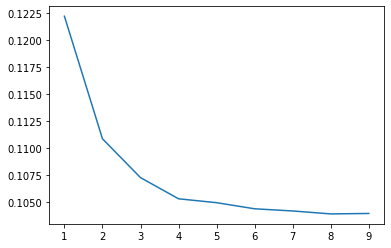

In [64]:
ranks = range(1,10)
errs = []
for rank in ranks:
    differ = DiffusionNMF(D, K, ncomponents = rank, iterations = 5000, tol = 1e-30)
    differ.solver('MultUpdate', sparseness = None)
    err = np.linalg.norm(D - np.dot(differ.X, np.dot(differ.V, K))) / np.linalg.norm(D)
    errs.append(err)
    
plt.plot(ranks, errs)

In [65]:
rank = 5

#### sparseness

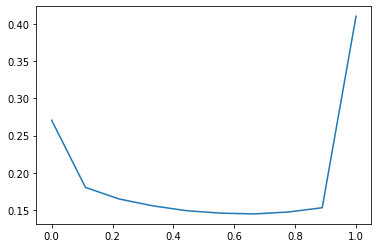

In [57]:
# find an appropriate value for sparseness:
sparz = np.linspace(0,1,10)
s_errs = []
for s in sparz:
    differ = DiffusionNMF(D, K, ncomponents = rank, iterations = 5000, tol = 1e-30)
    differ.solver('HoyerP', sparseness = s)
    err = np.linalg.norm(D - np.dot(differ.X, np.dot(differ.V, K))) / np.linalg.norm(D)
    s_errs.append(err)
    
plt.plot(sparz, s_errs)

In [48]:
sparseness = 0.55

#### Beta

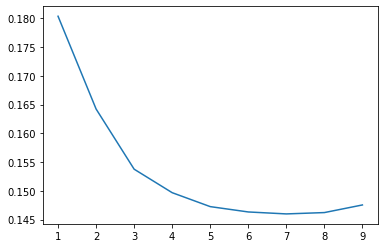

In [59]:
betas = range(1,10)
b_errs = []
for b in betas:
    kb = np.linalg.inv(I + b * state_L)
    differ = DiffusionNMF(D, kb, ncomponents = 4, iterations = 5000, tol = 1e-30)
    differ.solver('HoyerP', sparseness = sparseness)
    err = np.linalg.norm(D - np.dot(differ.X, np.dot(differ.V, K))) / np.linalg.norm(D)
    b_errs.append(err)
    
plt.plot(betas, b_errs)

In [16]:
differ = DiffusionNMF(D, K, ncomponents = 4, iterations = 5000, tol = 1e-20)

<AxesSubplot:>

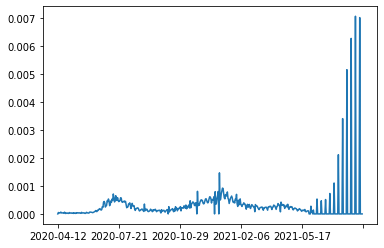

In [30]:
new_case_dset.dataframe.loc[:,'Florida'].plot()

<AxesSubplot:>

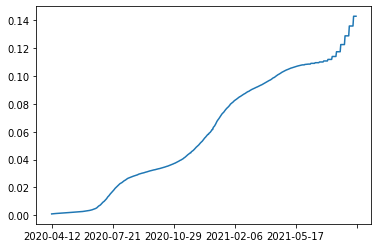

In [31]:
state_norm.dataframe.loc[:,'Florida'].plot()

### Multiplicative Update

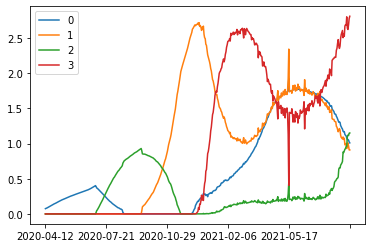

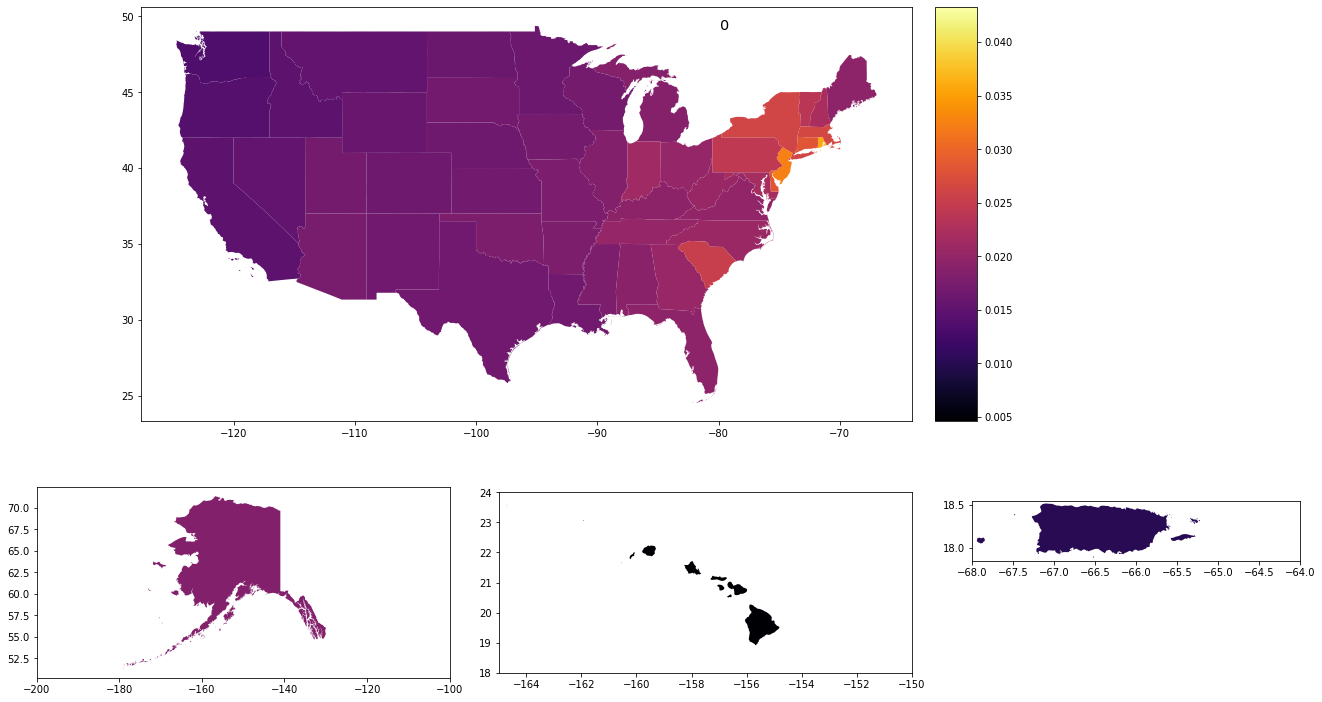

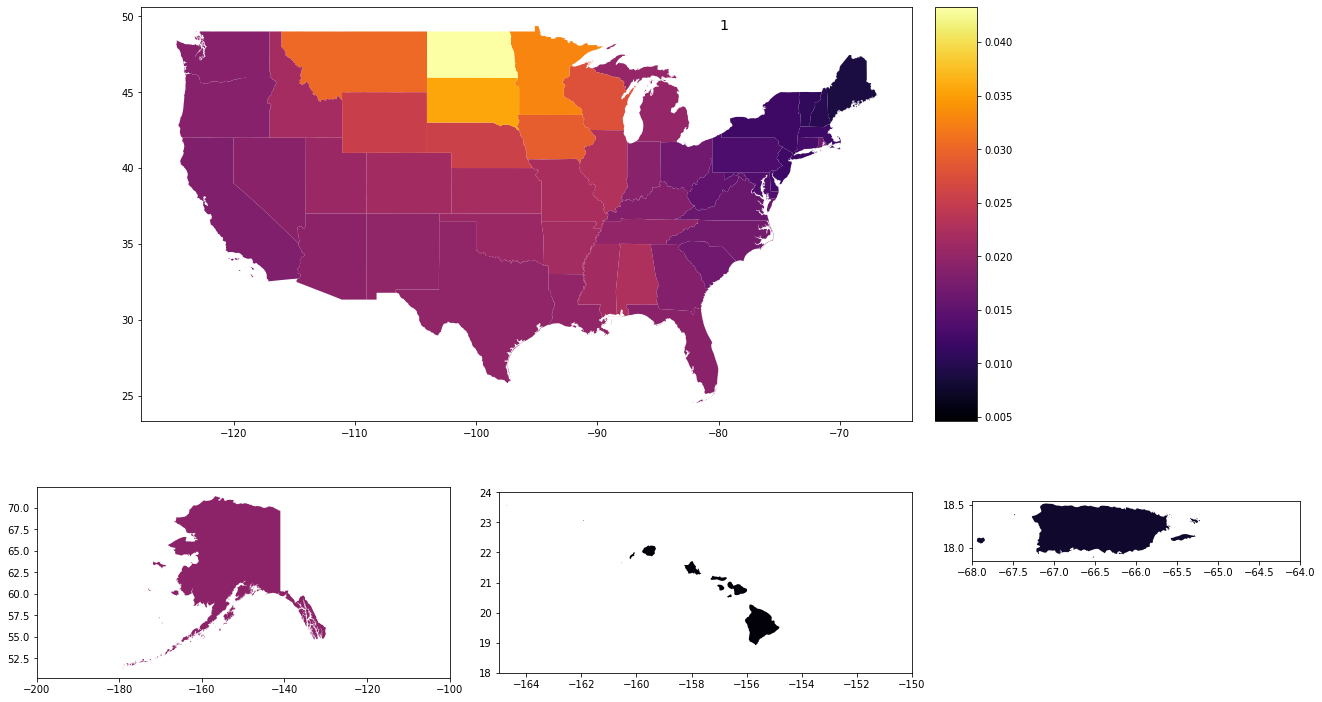

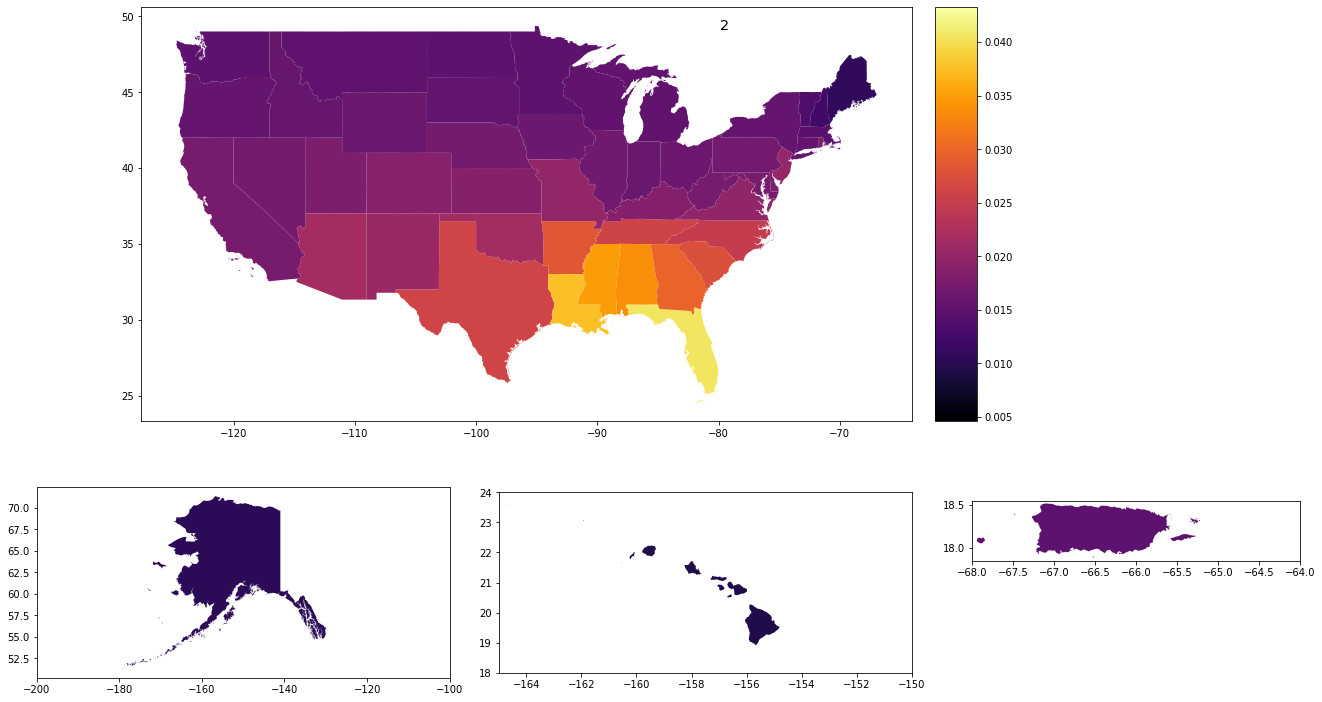

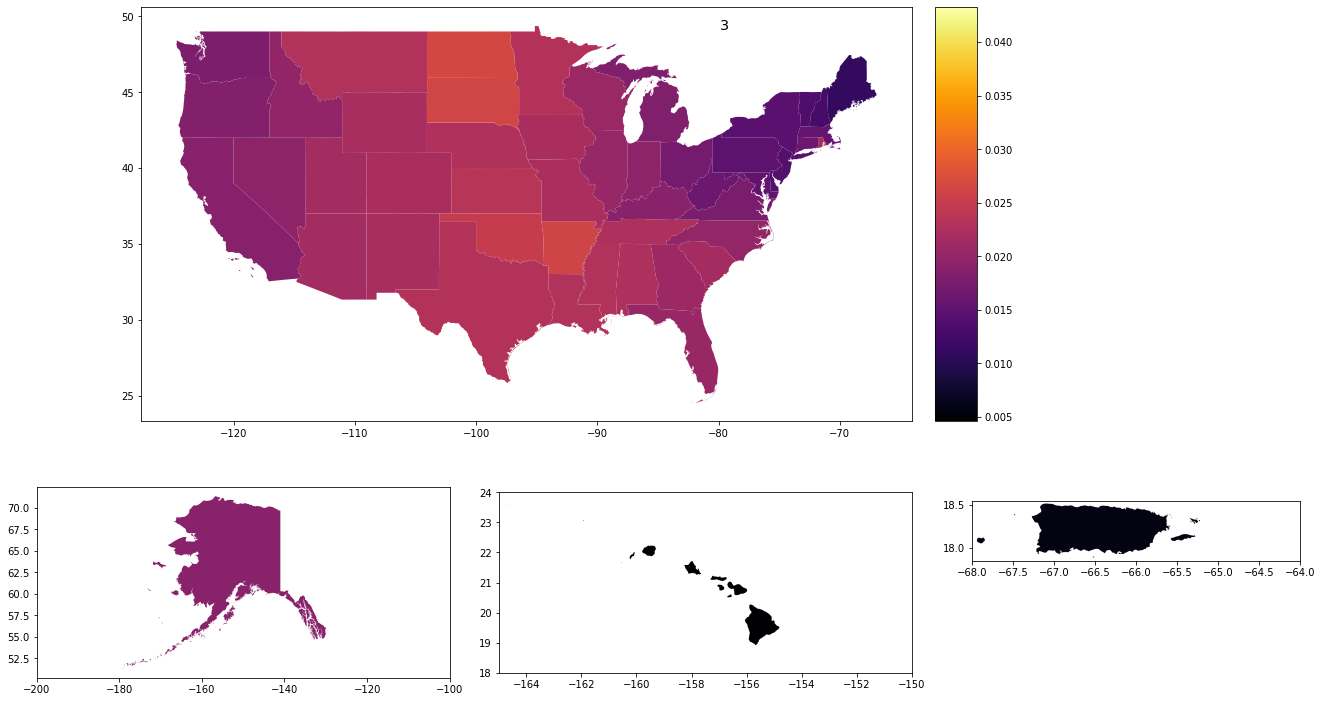

In [60]:
differ.solver('MultUpdate')
x,v = rescale(differ.X, differ.V, K)
vk = np.dot(v, K)
diffX = pd.DataFrame(x, index = state_dset.dataframe.index)
diffVK = pd.DataFrame(vk, columns = state_dset.dataframe.columns)
diffX.plot()
state_map_basis(diffVK)

### Hoyer Projection

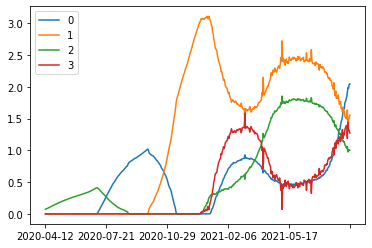

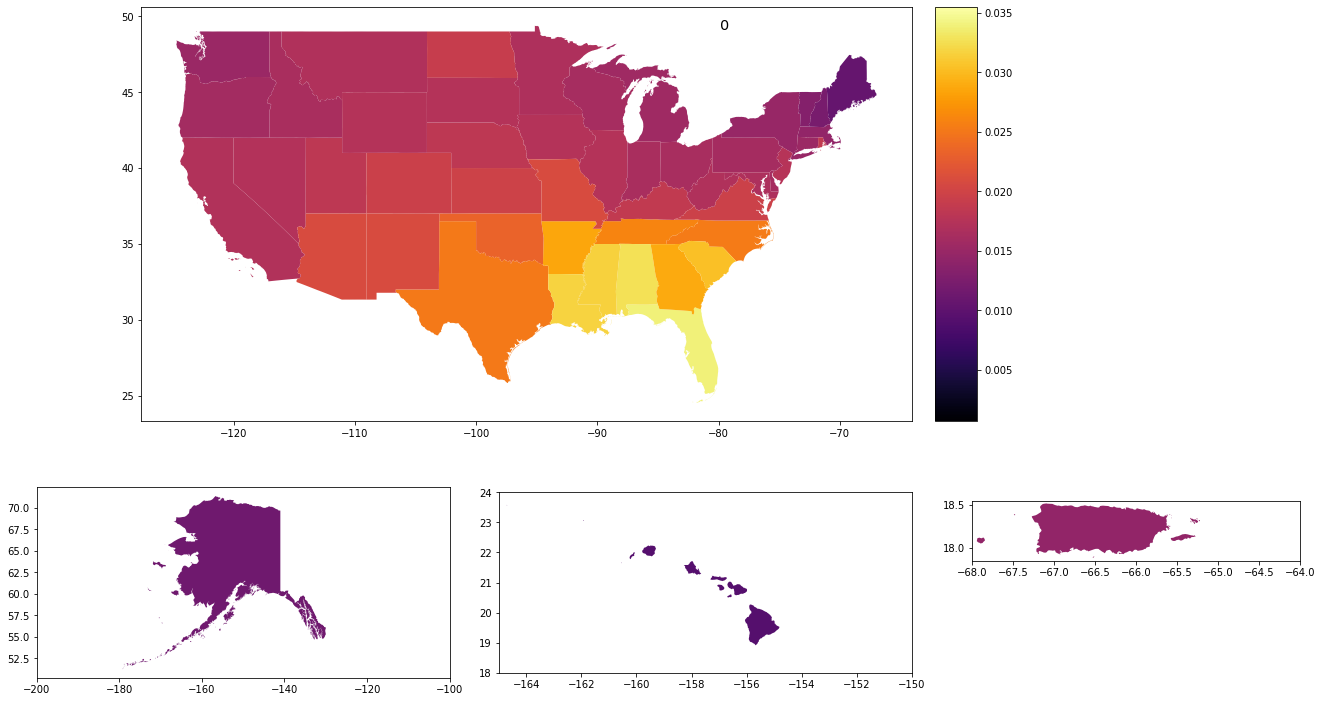

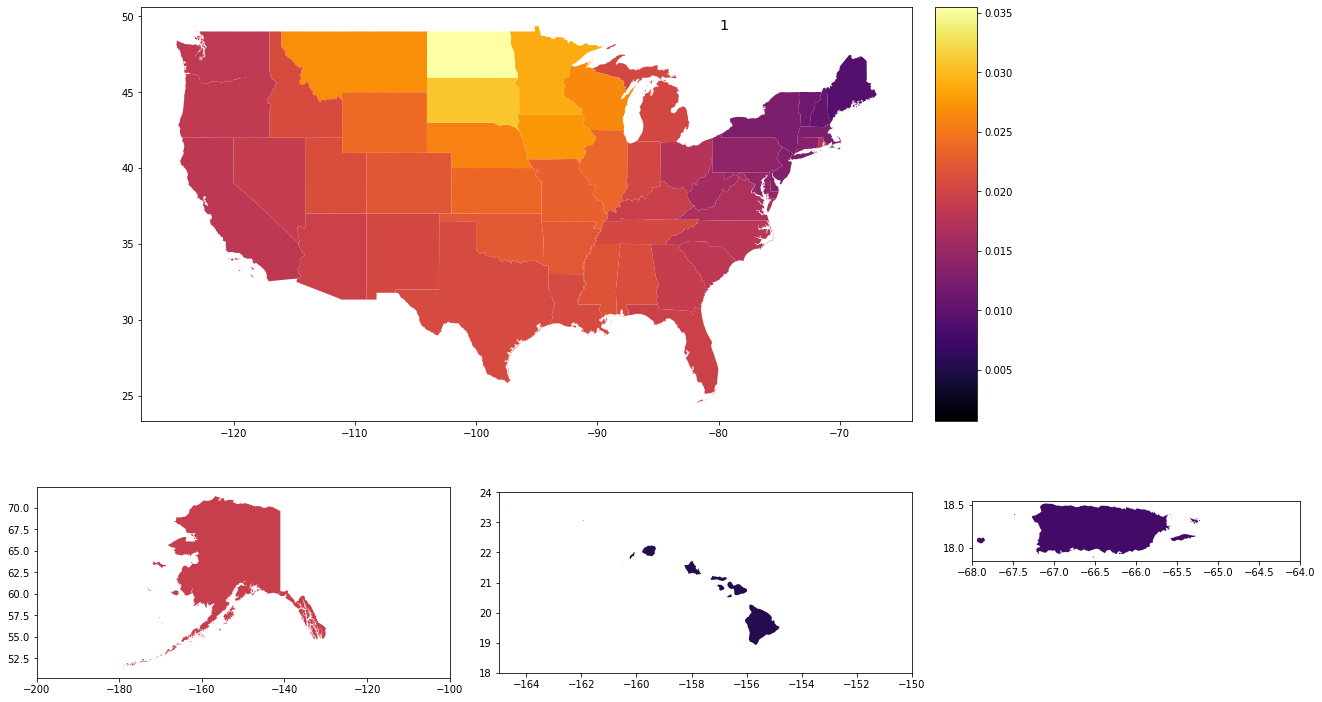

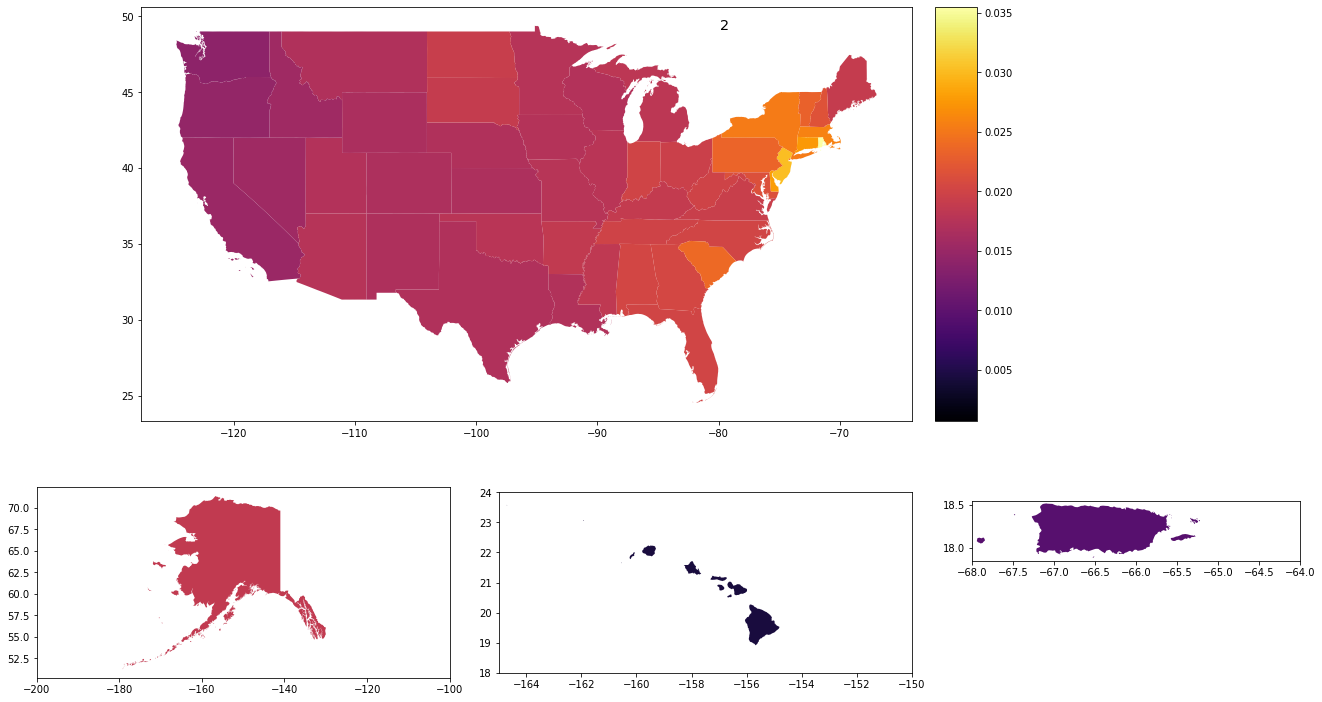

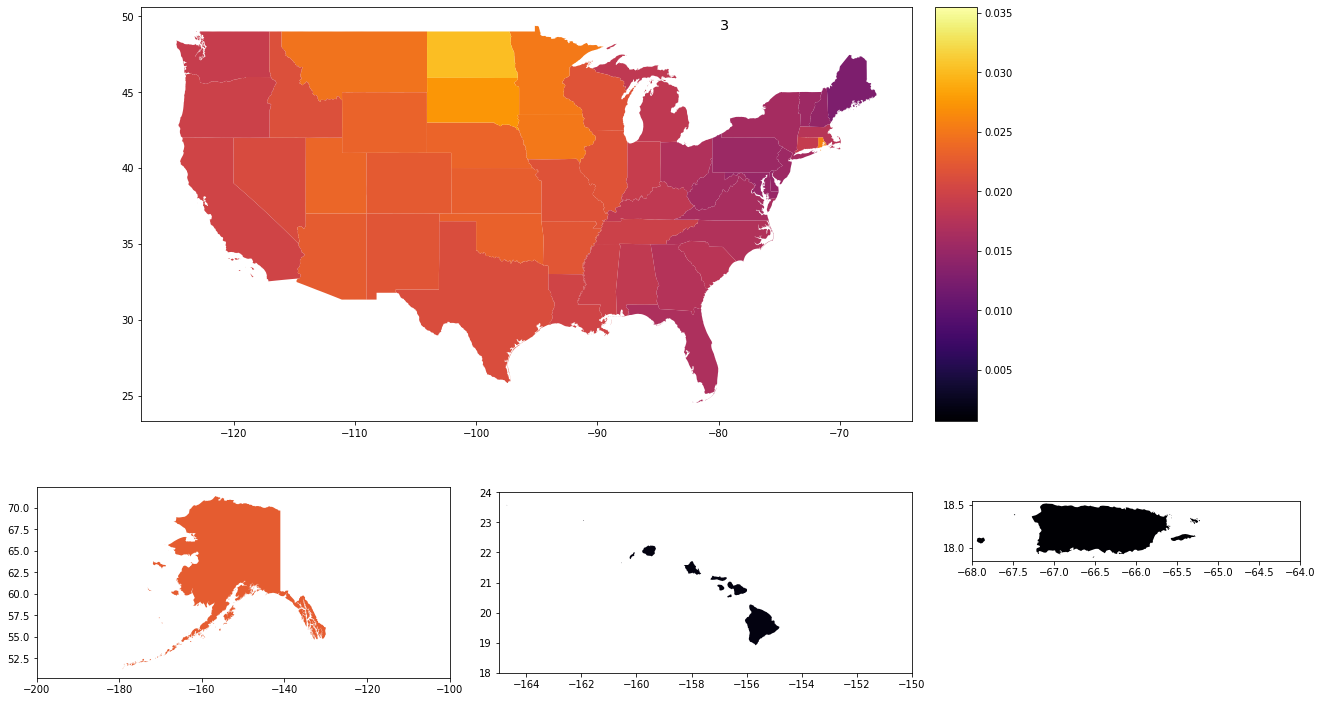

In [61]:
differ.solver('HoyerP', sparseness = 0.6)
x,v = rescale(differ.X, differ.V, K)
vk = np.dot(v, K)
diffX = pd.DataFrame(x, index = state_dset.dataframe.index)
diffVK = pd.DataFrame(vk, columns = state_dset.dataframe.columns)
diffX.plot()
state_map_basis(diffVK)

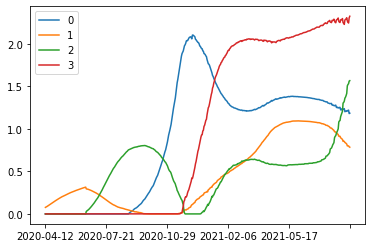

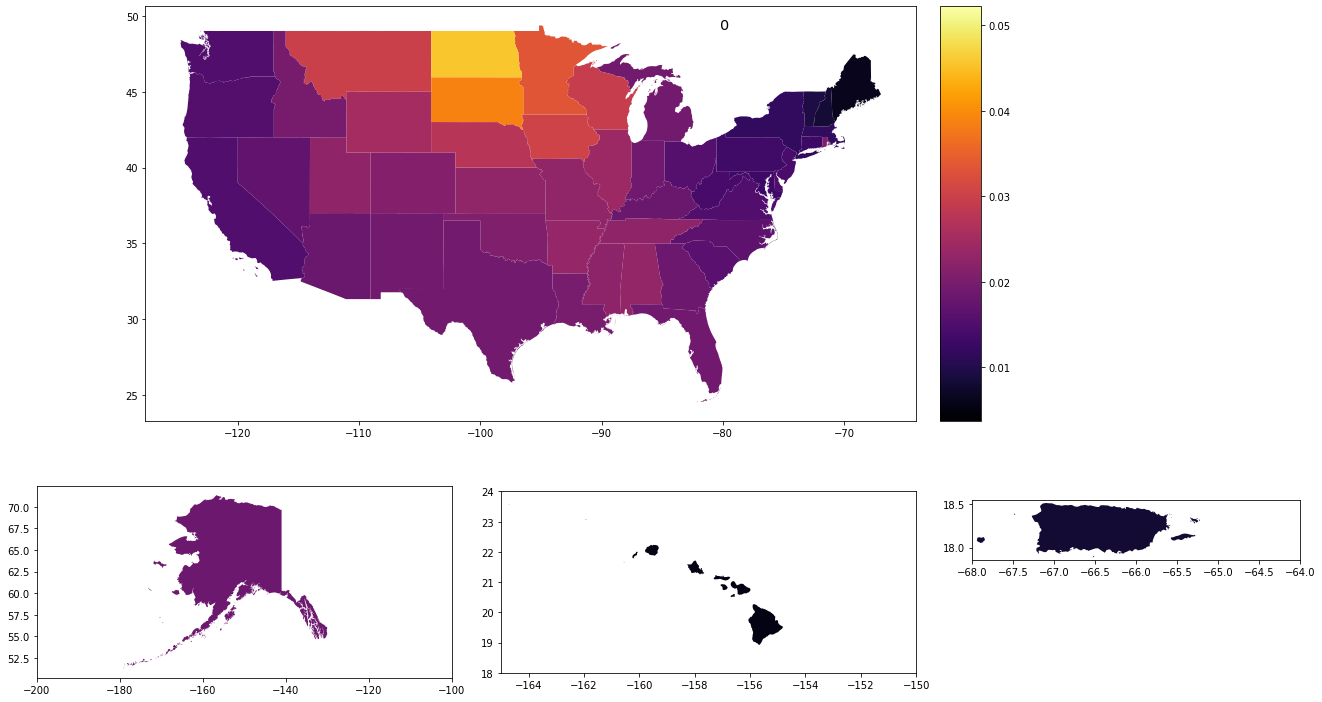

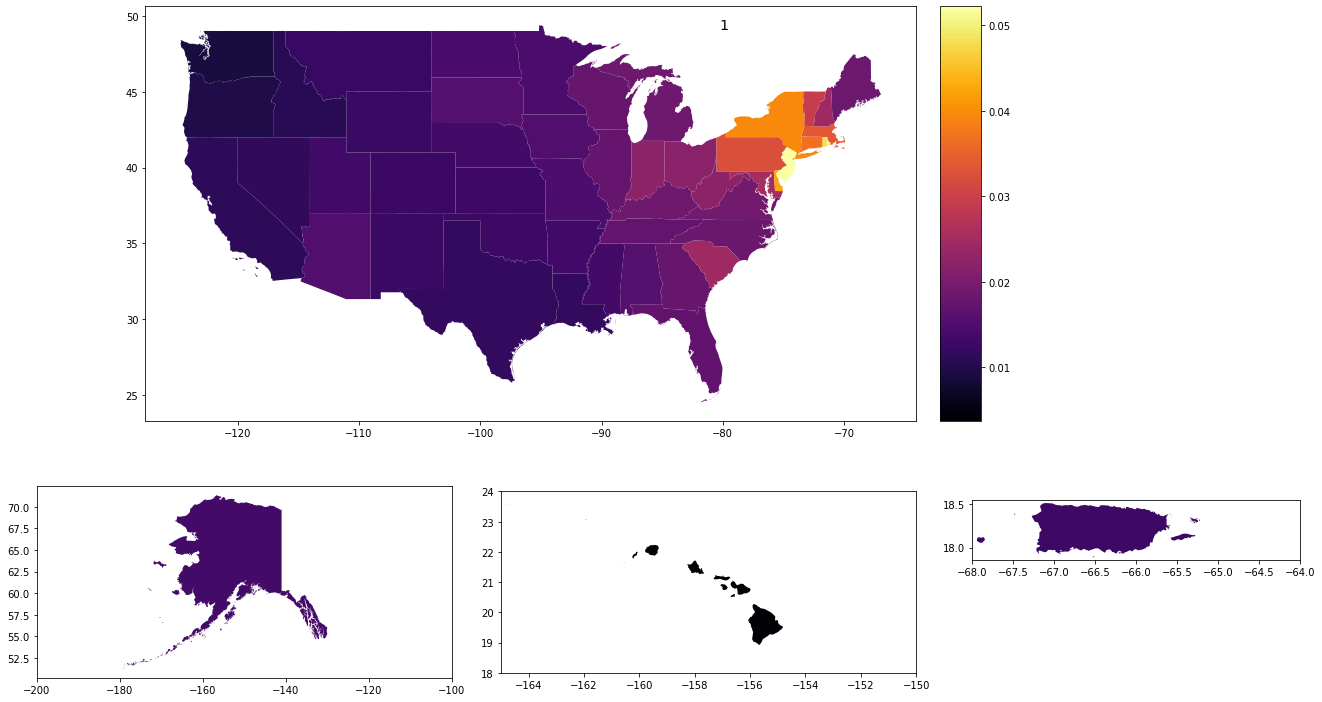

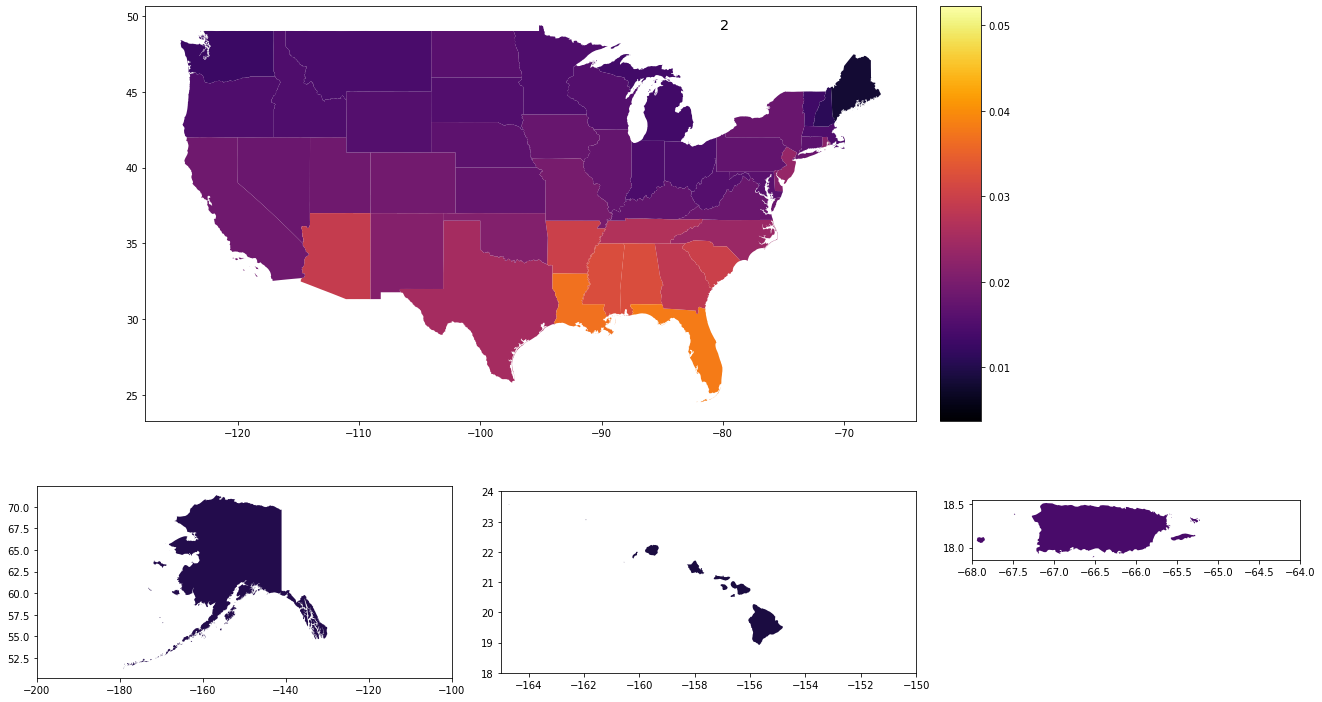

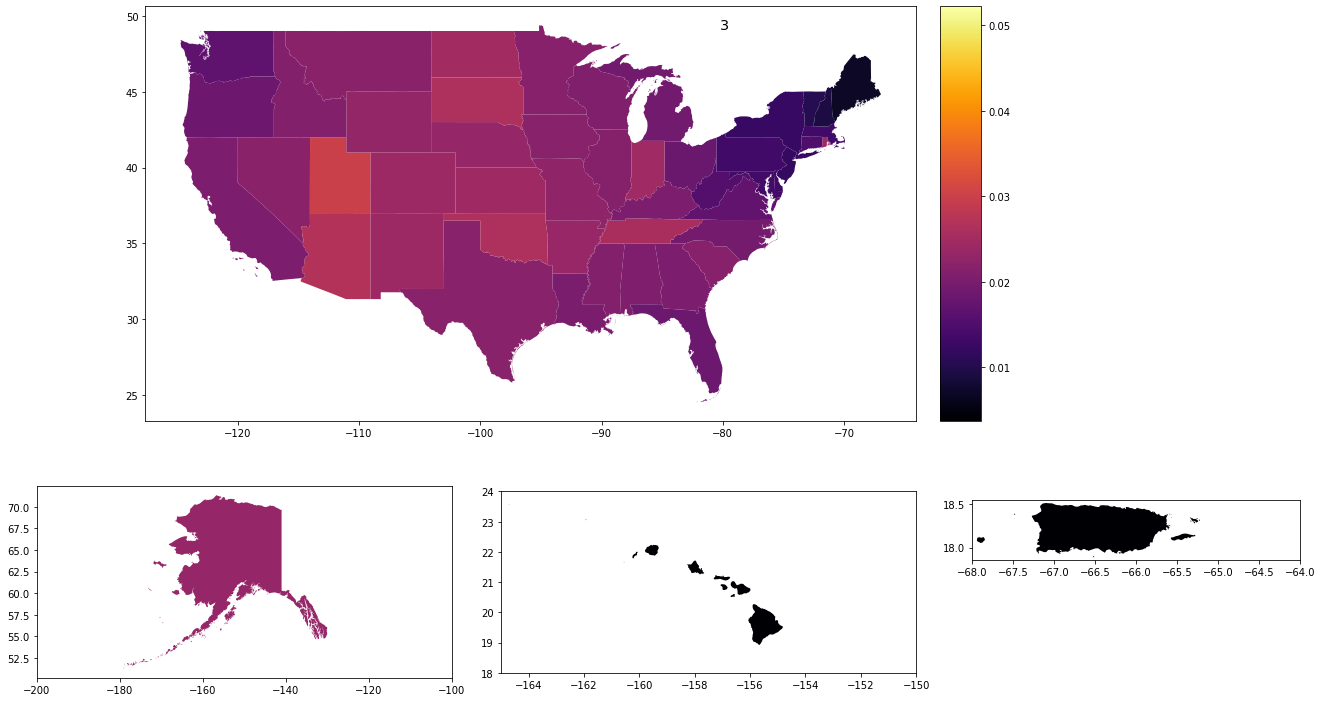

In [40]:
differ.solver('MultProj', sparseness = 0.6)
x,v = rescale(differ.X, differ.V, K)
vk = np.dot(v,K)
diffX = pd.DataFrame(x, index = state_dset.dataframe.index)
diffVK = pd.DataFrame(vk, columns = state_dset.dataframe.columns)
diffX.plot()
state_map_basis(diffVK)

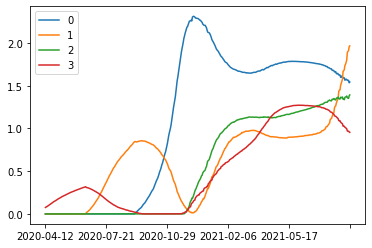

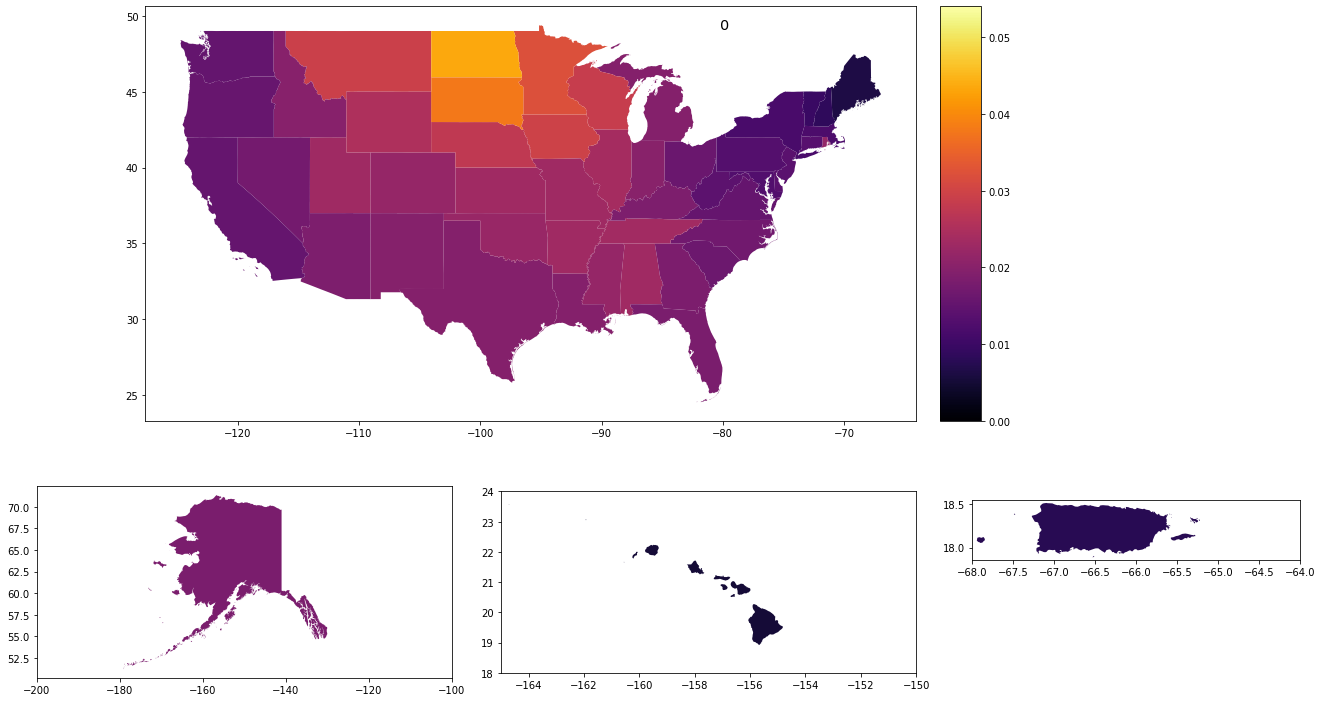

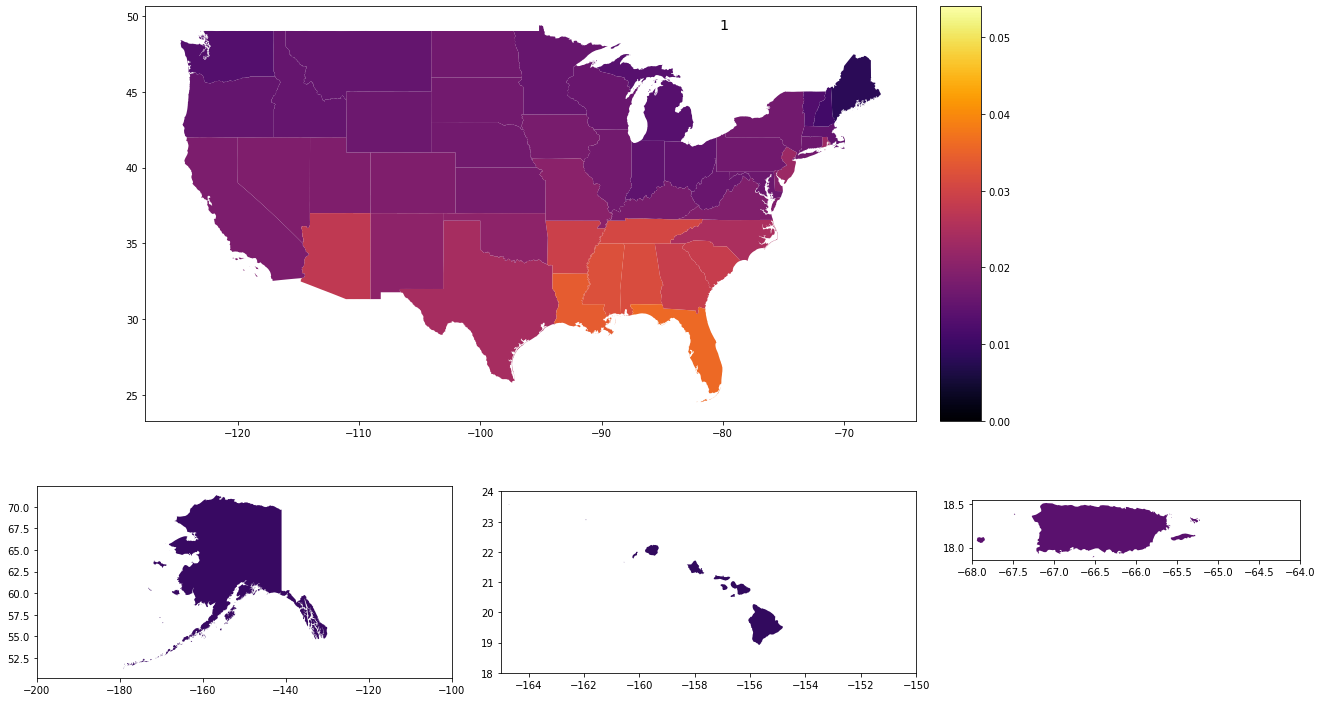

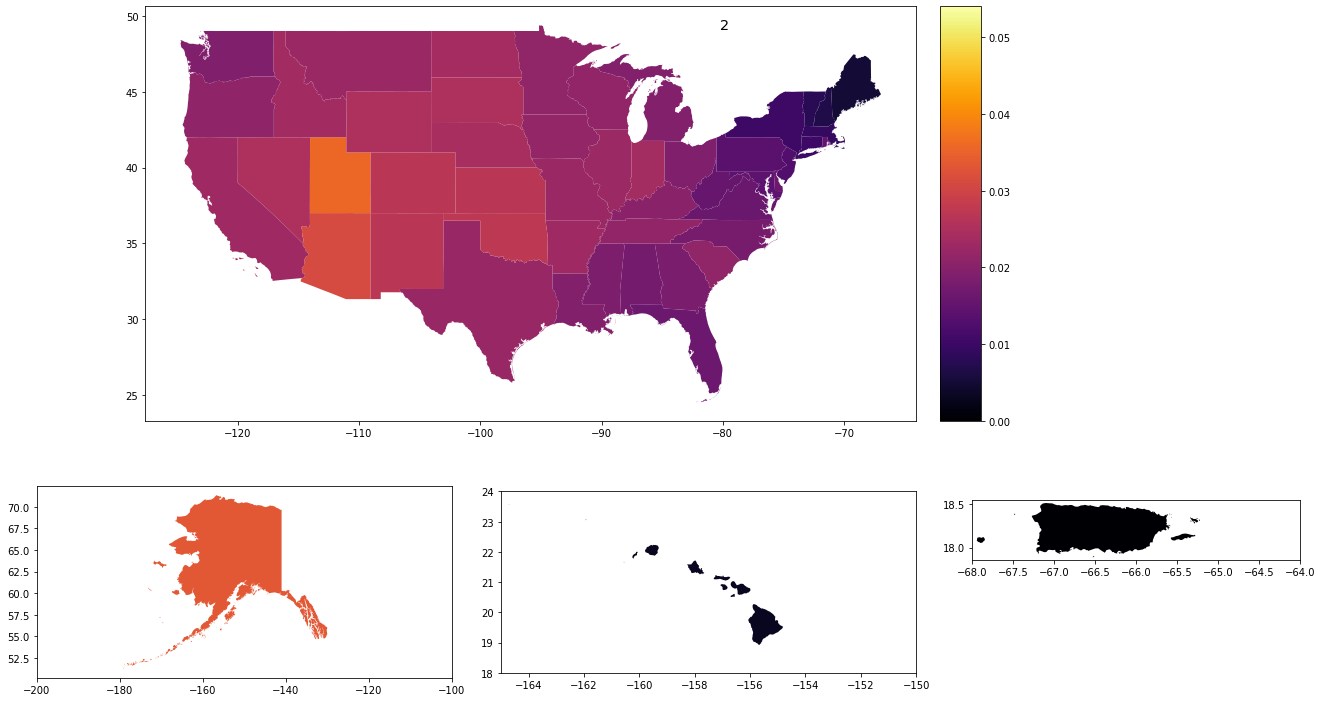

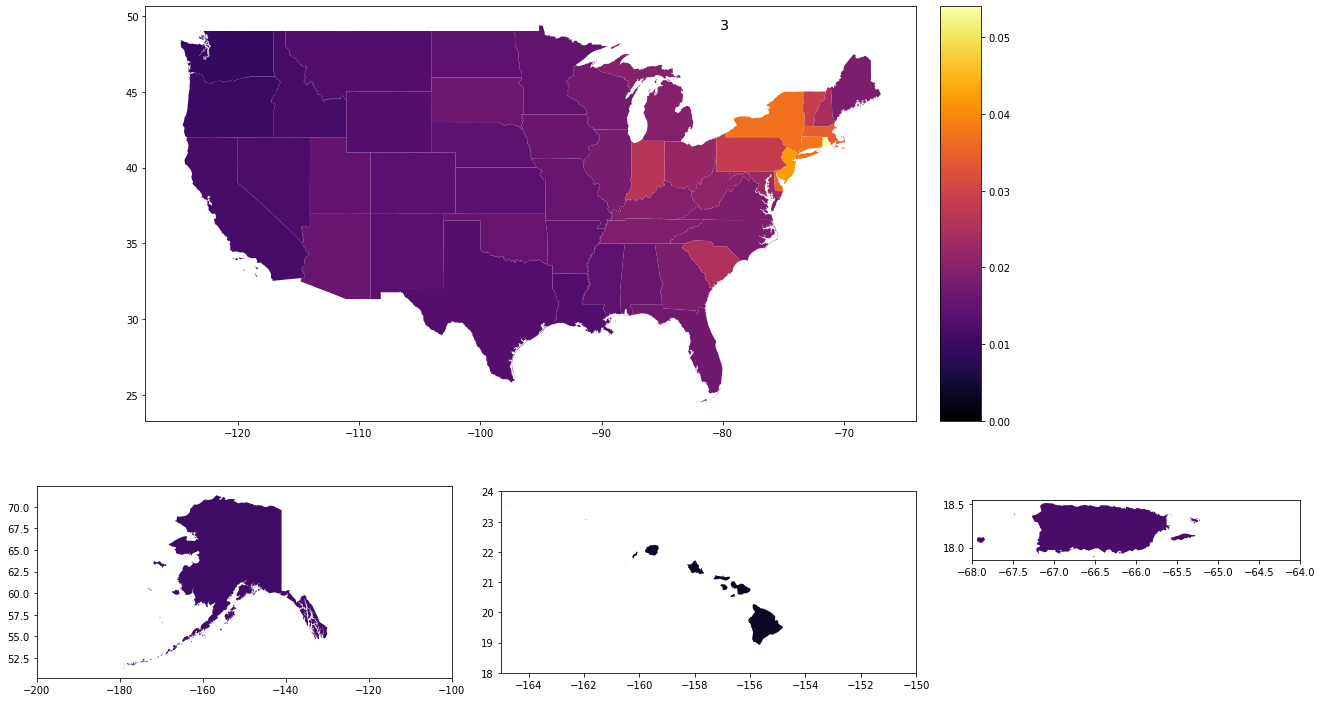

In [41]:
differ.solver('TwoPhase', sparseness = 0.6)
x,v = rescale(differ.X, differ.V, K)
vk = np.dot(v,K)
diffX = pd.DataFrame(x, index = state_dset.dataframe.index)
diffVK = pd.DataFrame(vk, columns = state_dset.dataframe.columns)
diffX.plot()
state_map_basis(diffVK)